Summary of content:

- data cleaning/preprocessing/visualization
- clustering - segmentation
  - traditional approach
  - kmean, mean-shift, k-modes, and k-prototypes
  - PCA for visualization
  - pick optimal number of clusters
- regression - predict customers' revenue
- classification - predict customers' churn

# 1- preprocess data

Summary of tasks
- collect and combine data from different sources (assume already done)
- clean data
  - examin data type and correct them if needed
  - address missing values
  - check statistical info for numeric features
  - check categories for categorical features
  - address inconsistencies and potential corrections needed for features (combine or rename)

  

  __Example:  Clean `sales.csv` dataset__

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load sales data
root  = '/content/drive/MyDrive/Interview/UPS'
sales01 = pd.read_csv(f'{root}/sales_01.csv')
display(sales01.shape, sales01.head())

(100, 12)

,Year,Product,line,Product.1,type,Product.2,Order,method,type.1,Retailer,country,Revenue
0,2004,Camping,Equipment,Cooking,Gear,TrailChef,Water,Bag,Telephone,United,States,315044.33
1,2004,Camping,Equipment,Cooking,Gear,TrailChef,Water,Bag,Telephone,Canada,NaN,14313.48
2,2004,Camping,Equipment,Cooking,Gear,TrailChef,Water,Bag,Telephone,Mexico,NaN,156644.47
3,2004,Camping,Equipment,Cooking,Gear,TrailChef,Water,Bag,Telephone,Brazil,NaN,59191.72
4,2004,Camping,Equipment,Cooking,Gear,TrailChef,Water,Bag,Telephone,Japan,NaN,7029.33


In [ ]:
sales.columns

Index(['Year', 'Product_line', 'Product_type', 'Product_name', 'Order_method',
       'Retailer_country', 'Revenue', 'Date'],
      dtype='object')

In [ ]:
# step 1- check dtype of each column and inspect each column
sales01.dtypes

Year           int64
Product       object
line          object
Product.1     object
type          object
Product.2     object
Order         object
method        object
type.1        object
Retailer      object
country       object
Revenue      float64
dtype: object

In [ ]:
sales01.Revenue.describe()

count       100.000000
mean      75543.366300
std       70060.167447
min        6615.840000
25%       32575.022500
50%       59479.910000
75%       78551.192500
max      348446.250000
Name: Revenue, dtype: float64

In [ ]:
sales01.isnull().sum()

Year          0
Product       0
line          0
Product.1     0
type          0
Product.2     0
Order         0
method        0
type.1        0
Retailer      0
country      91
Revenue       0
dtype: int64

In [ ]:
sales01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Year              100 non-null    int32         
 1   Product_line      100 non-null    string        
 2   Product_type      100 non-null    string        
 3   Product_name      100 non-null    object        
 4   Order_method      100 non-null    string        
 5   Retailer_country  100 non-null    string        
 6   Revenue           100 non-null    float32       
 7   Date              100 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float32(1), int32(1), object(1), string(4)
memory usage: 5.6+ KB


In [ ]:
# Step 1- correct dtype
sales01['Date'] = pd.to_datetime(sales01['Year'], format='%Y')
sales01['Year'] = sales01['Date'].dt.year
for col in sales01.columns[1:-2]:
  sales01[col] = sales01[col].astype("string")
sales01.Revenue = sales01.Revenue.astype(np.float32)
sales01.dtypes

Year                  int32
Product      string[python]
line         string[python]
Product.1    string[python]
type         string[python]
Product.2    string[python]
Order        string[python]
method       string[python]
type.1       string[python]
Retailer     string[python]
country      string[python]
Revenue             float32
Date         datetime64[ns]
dtype: object

In [ ]:
# Step 2: Fill NA with single space
sales01.country.fillna(' ', inplace=True)

In [ ]:
# Step 3:
'''
correct columns by combining the following columns:
 Product and line; Product.1 and type; Product.2 + Order + method; Retailer + country
convert column name:
 'Product': 'Product_line','Product.1':'Product_type','Retailer':'Retailer_country','Product.2':'Product_name','type.1': 'Order_method'
drop extra columns:
 ['line', 'type', 'Order', 'method', 'country']
'''

sales01['Product'] = sales01['Product'] + ' ' + sales01['line']
sales01['Product.1'] = sales01['Product.1'] + ' ' + sales01['type']
sales01['Retailer'] = sales01['Retailer'] + ' '+ sales01['country']
sales01['Product.2'] = sales01[['Product.2','Order','method']].agg(' '.join, axis = 1)
sales01.rename(columns = {'Product': 'Product_line','Product.1':'Product_type','Retailer':'Retailer_country','Product.2':'Product_name','type.1': 'Order_method'}, inplace=True)
sales01.drop(columns=['line', 'type', 'Order', 'method', 'country'], inplace=True)


In [ ]:
sales01.head(4)

,Year,Product_line,Product_type,Product_name,Order_method,Retailer_country,Revenue,Date
0,2004,Camping Equipment,Cooking Gear,TrailChef Water Bag,Telephone,United States,315044.343750,2004-01-01
1,2004,Camping Equipment,Cooking Gear,TrailChef Water Bag,Telephone,Canada,14313.480469,2004-01-01
2,2004,Camping Equipment,Cooking Gear,TrailChef Water Bag,Telephone,Mexico,156644.468750,2004-01-01
3,2004,Camping Equipment,Cooking Gear,TrailChef Water Bag,Telephone,Brazil,59191.718750,2004-01-01


# 2- exploration

Goal: analyze relationship btw features and target metrics such as key performance indicators (KPIs), such as revenue, profit, customer life profit, costumer aquisition cost, conversion rate, and churn.

### Example: explore attributes in the `sales' dataset and generate KPIs

Generate a report consist of the following KPIs

1. product with maximum revenue contribution
2. order method with the highest count of sales
3. markets with positive gross profit
4. coutry with the least revenue btw 2004-2007
5. coutry with the highest revenue btw 2004-2007

In [ ]:
import pandas as pd
import numpy as np


root = '/content/drive/MyDrive/Interview/UPS'
sales02 = pd.read_csv(f'{root}/sales_02.csv')
display(sales02.shape, sales02.head(3))

(17823, 14)

,Year,Product line,Product type,Product,Order method type,Retailer country,Revenue,Planned revenue,Product cost,Quantity,Unit cost,Unit price,Gross profit,Unit sale price
0,2004,Golf Equipment,Golf Accessories,Course Pro Golf and Tee Set,Sales visit,United States,5819.70,6586.16,1733.2,619.0,2.8,10.64,4086.50,5.105
1,2004,Golf Equipment,Golf Accessories,Course Pro Golf and Tee Set,Sales visit,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2005,Golf Equipment,Golf Accessories,Course Pro Golf and Tee Set,Sales visit,United States,10904.28,11363.52,2990.4,1068.0,2.8,10.64,7913.88,10.210


In [ ]:
sales02.columns

Index(['Year', 'Product line', 'Product type', 'Product', 'Order method type',
       'Retailer country', 'Revenue', 'Planned revenue', 'Product cost',
       'Quantity', 'Unit cost', 'Unit price', 'Gross profit',
       'Unit sale price'],
      dtype='object')

In [ ]:
sales02.dtypes

Year                   int64
Product line          object
Product type          object
Product               object
Order method type     object
Retailer country      object
Revenue              float64
Planned revenue      float64
Product cost         float64
Quantity             float64
Unit cost            float64
Unit price           float64
Gross profit         float64
Unit sale price      float64
dtype: object

In [ ]:
sales02.isnull().sum()

Year                     0
Product line             0
Product type             0
Product                  0
Order method type        0
Retailer country         0
Revenue              11778
Planned revenue      11778
Product cost         11778
Quantity             11963
Unit cost            11778
Unit price           11778
Gross profit         11778
Unit sale price      11778
dtype: int64

In [ ]:
# drop rows with no data 11778
sales02.dropna(subset=["Revenue"], inplace=True, axis=0)

In [ ]:
sales02.isnull().sum()

Year                   0
Product line           0
Product type           0
Product                0
Order method type      0
Retailer country       0
Revenue                0
Planned revenue        0
Product cost           0
Quantity             185
Unit cost              0
Unit price             0
Gross profit           0
Unit sale price        0
dtype: int64

In [ ]:
# Generate repot
# 1. product with maximum revenue contribution

max_rev_prod = sales02.groupby('Product line')['Revenue'].sum().sort_values(ascending=False).head(1).item()
print (f'1. product with maximum revenue contribution: {max_rev_prod}')
# 2. order method with the highest count sales
max_method_count = sales02['Order method type'].value_counts().head(1).item()
print (f'2. order method with the highest count of sales: {max_method_count}')
# 3. markets with positive gross profit
max_profit_markets = [market for market, gross_profit in sales02.groupby('Retailer country')['Gross profit'].sum().items() if gross_profit > 0]
print (f'3. markets with positive gross profit: {max_profit_markets}')
# 4. coutry with the least revenue btw 2004-2007
least_rev_country = sales02.groupby('Retailer country')['Revenue'].sum().idxmin()
print (f"4. coutry with the least revenue btw 2004-2007: {least_rev_country}")
# 5. coutry with the highest revenue btw 2004-2007
max_rev_country = sales02.groupby('Retailer country')['Revenue'].sum().idxmax()
print (f"5. coutry with the highest revenue btw 2004-2007: {max_rev_country}")

1. product with maximum revenue contribution: 486006516.22
2. order method with the highest count of sales: 2293
3. markets with positive gross profit: ['Australia', 'Austria', 'Belgium', 'Brazil', 'Canada', 'China', 'Denmark', 'Finland', 'France', 'Germany', 'Italy', 'Japan', 'Korea', 'Mexico', 'Netherlands', 'Singapore', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom', 'United States']
4. coutry with the least revenue btw 2004-2007: Denmark
5. coutry with the highest revenue btw 2004-2007: United States


### Example: Calculating Conversion Ratios for Website Ads.

Dataset contains two columns: converted and group. If an advertisement succeeds in getting a user to click on it, the converted field gets the value 1, otherwise, it gets 0 by default; the group field denotes which ad was clicked: A or B.

Goal: modify the dataset to show, in one table, information about:

- The number of views ads in each group got.
- The number of ads converted in each group.
- The conversion ratio for each group

In [ ]:
# Load dataset
conv_df = pd.read_csv(f'{root}/03conversion_rates.csv')
display(conv_df.shape, conv_df.head(3))

(2000, 2)

,converted,group
0,0,B
1,0,B
2,0,A


In [ ]:
# step 1: number of views by ads group
result = conv_df.groupby('group')['converted'].count().reset_index()
result.columns = ['group', 'views']
result

,group,views
0,A,1030
1,B,970


In [ ]:
# step 2: total number of clicks by ads. group
conv_df.groupby('group')['converted'].sum().reset_index()

,group,converted
0,A,90
1,B,21


In [ ]:
# merge result from step 1 and step 2
result = pd.merge(conv_df.groupby('group')['converted'].sum().reset_index(), result, on='group')
result

,group,converted,views
0,A,90,1030
1,B,21,970


In [ ]:
# step 3: compute conversion ratio
result = result.assign(conversion_ratio=result['converted']/result['views'])
result.set_index('group')

,converted,views,conversion_ratio
group,,,
A,90,1030,0.087379
B,21,970,0.021649


In [ ]:
result.set_index('group').stack()

group                  
A      converted             90.000000
       views               1030.000000
       conversion_ratio       0.087379
B      converted             21.000000
       views                970.000000
       conversion_ratio       0.021649
dtype: float64

# 3- visualization

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

### Example sales via visualization

- Which mode of order generates the most revenue?
- How have the following parameters varied over four years: Revenue,
 Planned revenue, and Gross profit?

In [ ]:
sales02.head(2)

,Year,Product line,Product type,Product,Order method type,Retailer country,Revenue,Planned revenue,Product cost,Quantity,Unit cost,Unit price,Gross profit,Unit sale price
0,2004,Golf Equipment,Golf Accessories,Course Pro Golf and Tee Set,Sales visit,United States,5819.70,6586.16,1733.2,619.0,2.8,10.64,4086.50,5.105
2,2005,Golf Equipment,Golf Accessories,Course Pro Golf and Tee Set,Sales visit,United States,10904.28,11363.52,2990.4,1068.0,2.8,10.64,7913.88,10.210


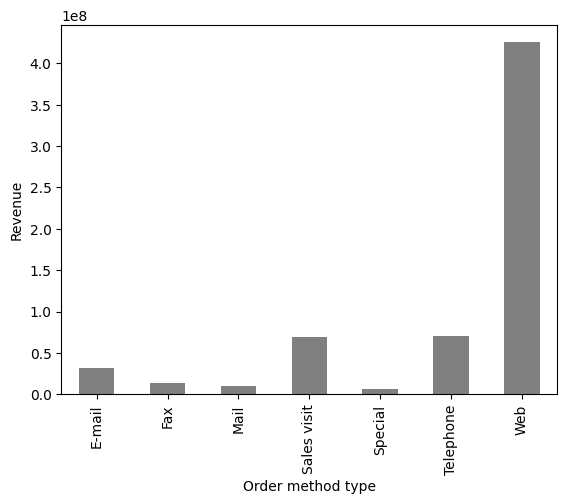

In [ ]:
sales02.groupby('Order method type')['Revenue'].sum().plot(kind='bar', xlabel='Order method type', ylabel='Revenue',color='gray')
plt.show()


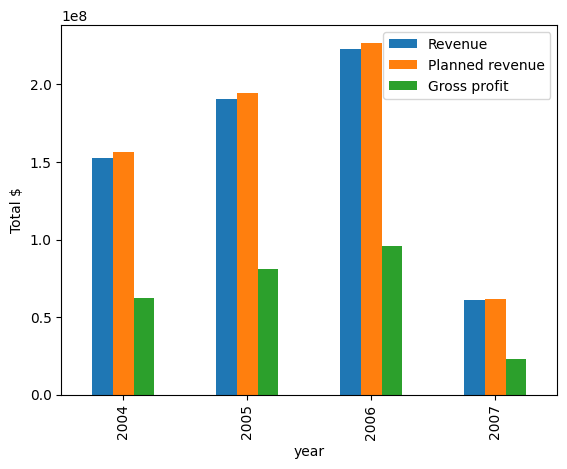

In [ ]:
sales02.groupby('Year').agg({'Revenue':'sum','Planned revenue':'sum','Gross profit':'sum'}).plot(kind='bar', xlabel='year', ylabel='Total $')
plt.show()

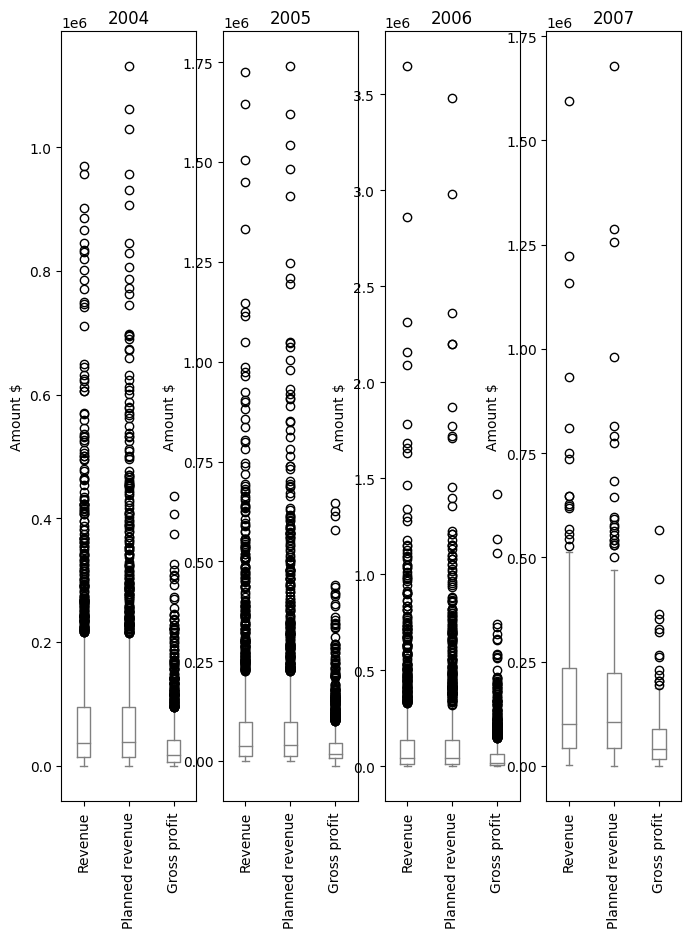

In [ ]:


fig, axs = plt.subplots(1,4, figsize=(8, 10))

sales02[sales02['Year'] == 2004].loc[:,['Revenue','Planned revenue', 'Gross profit']].plot(kind='box',title='2004', ylabel='Amount $',color='gray', ax=axs[0], rot=90)
sales02[sales02['Year'] == 2005].loc[:,['Revenue','Planned revenue', 'Gross profit']].plot(kind='box',title='2005', ylabel='Amount $',color='gray', ax=axs[1], rot=90)
sales02[sales02['Year'] == 2006].loc[:,['Revenue','Planned revenue', 'Gross profit']].plot(kind='box',title='2006', ylabel='Amount $',color='gray', ax=axs[2], rot=90)
sales02[sales02['Year'] == 2007].loc[:,['Revenue','Planned revenue', 'Gross profit']].plot(kind='box',title='2007', ylabel='Amount $',color='gray', ax= axs[3], rot=90)

plt.show()

### Visualize advertisement campaign

Goal: Given the result of an advertisement campaign through multiple mediums, investigate the result and provide an insight through visualization.

# 4- Customer segmentation

Method: clustering via k-mean

- choosing the features for clustering
- perform clustering
- summarize each clusters' characteristics



## Segmentation when we know which features to pick for segmentation

### Example 1: segment mall customer for more effective marketing communication

In [ ]:
# load mall_customers.csv data
root  = '/content/drive/MyDrive/Interview/UPS'
mall_customers = pd.read_csv(f'{root}/Mall_Customers.csv')
display(mall_customers.shape, mall_customers.head(), mall_customers.dtypes)

(200, 5)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

In [ ]:
print(f'null values count:\n{mall_customers.isnull().sum()}\n')
print(f'unique values count:\n{mall_customers.nunique()}\n')
mall_customers.info()

null values count:
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

unique values count:
CustomerID                200
Gender                      2
Age                        51
Annual Income (k$)         64
Spending Score (1-100)     84
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


__Approach 1: traditional approach__

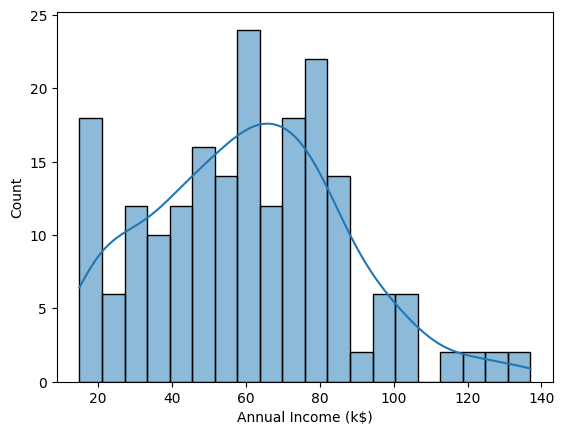

In [ ]:
# ruled-based segmentation based on income
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(data=mall_customers, x='Annual Income (k$)', bins = 20,kde=True)
plt.show()


In [ ]:
# divide into 4 cluster: low , med , high , very_high
bins =[0,30,60,90,150]
mall_customers["cluster"] = pd.cut(mall_customers["Annual Income (k$)"], bins=bins, labels=["low", "med", "high", "very_high"],)
mall_customers.head()


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,1,Male,19,15,39,low
1,2,Male,21,15,81,low
2,3,Female,20,16,6,low
3,4,Female,23,16,77,low
4,5,Female,31,17,40,low


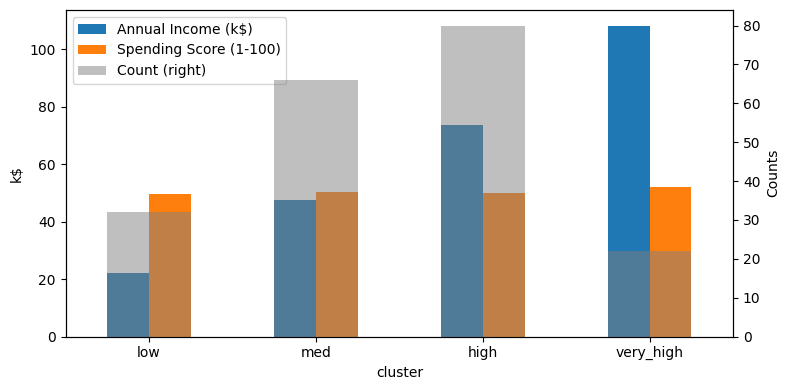

In [ ]:
# Group by 'cluster' and calculate means for 'Annual Income (k$)' and 'Spending Score (1-100)'
grouped_mean = mall_customers.groupby('cluster').agg(
    {
    'Annual Income (k$)': 'mean',
    'Spending Score (1-100)': 'mean'
    })
# Group by 'cluster' and count number of customers in each cluster
grouped_count = (mall_customers
                 .groupby('cluster')
                 .agg(
                     Count=pd.NamedAgg(column='CustomerID',
                                        aggfunc='count')
                     )
                 )

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(8, 4))

# Plot mean values for 'Annual Income (k$)' and 'Spending Score (1-100)'
grouped_mean.plot(kind='bar', ax=ax1, secondary_y='Count', rot=0)
ax1.set_xlabel('Cluster by Income')
ax1.set_ylabel('k$')

# Plot count of customers in each cluster
grouped_count.plot(kind='bar', ax=ax1, color='gray', alpha=0.5, secondary_y=True, rot=0)
ax1.right_ax.set_ylabel('Counts')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [ ]:
mall_customers.groupby(by='cluster')['Annual Income (k$)'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
low,32.0,22.000000,4.765467,15.0,18.75,20.5,25.75,30.0
med,66.0,47.424242,8.250055,33.0,40.00,48.0,54.00,60.0
high,80.0,73.725000,8.346871,61.0,66.50,73.5,78.00,88.0
very_high,22.0,108.181818,13.661334,93.0,98.25,103.0,118.25,137.0


__Approach 2: K-mean clustering__

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scaler = StandardScaler()
col_to_scale = ['Age','Annual Income (k$)', 'Spending Score (1-100)']
mall_customers_scaled = scaler.fit_transform(mall_customers
                                             .drop('cluster', axis=1)
                                             [col_to_scale]
                                             )
mall_customers_scaled[:4]

array([[-1.42456879, -1.73899919, -0.43480148],
       [-1.28103541, -1.73899919,  1.19570407],
       [-1.3528021 , -1.70082976, -1.71591298],
       [-1.13750203, -1.70082976,  1.04041783]])

In [ ]:
mall_customers_scaled_df = pd.DataFrame(mall_customers_scaled, columns=col_to_scale)
mall_customers_scaled_df = pd.concat([mall_customers_scaled_df, mall_customers[['CustomerID','Gender']]], axis=1)
mall_customers_scaled_df.head()

,Age,Annual Income (k$),Spending Score (1-100),CustomerID,Gender
0,-1.424569,-1.738999,-0.434801,1,Male
1,-1.281035,-1.738999,1.195704,2,Male
2,-1.352802,-1.700830,-1.715913,3,Female
3,-1.137502,-1.700830,1.040418,4,Female
4,-0.563369,-1.662660,-0.395980,5,Female


In [ ]:
# rearrange columns
mall_customers_scaled_df = mall_customers_scaled_df.iloc[:,[3,4,0,1,2]]
mall_customers_scaled_df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,-1.424569,-1.738999,-0.434801
1,2,Male,-1.281035,-1.738999,1.195704
2,3,Female,-1.352802,-1.700830,-1.715913
3,4,Female,-1.137502,-1.700830,1.040418
4,5,Female,-0.563369,-1.662660,-0.395980


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Count of customers per cluster: cluster
3    65
2    57
1    40
0    38
Name: count, dtype: int64


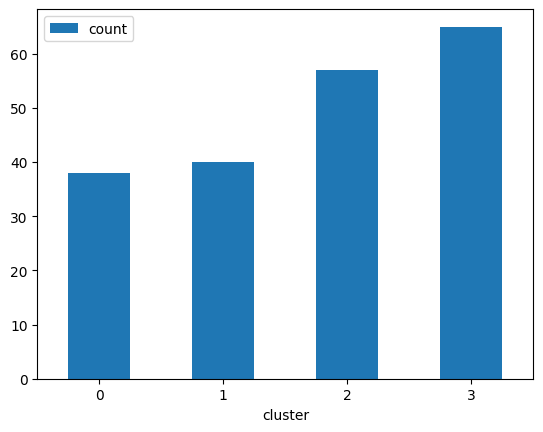

In [ ]:
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=4, random_state=42)
kmeans_model.fit(mall_customers_scaled_df[col_to_scale])
mall_customers_scaled_df['cluster'] = kmeans_model.labels_
print(f"Count of customers per cluster: {mall_customers_scaled_df.cluster.value_counts()}")

(mall_customers_scaled_df
 .groupby('cluster')
 .agg(count = pd.NamedAgg(column='CustomerID',aggfunc='count'))
 .plot(kind='bar',rot=0)
 )
plt.show()

In [ ]:
mall_customers_copy = mall_customers.copy()
mall_customers_copy['cluster'] = kmeans_model.labels_
mall_customers_copy.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,1,Male,19,15,39,2
1,2,Male,21,15,81,2
2,3,Female,20,16,6,2
3,4,Female,23,16,77,2
4,5,Female,31,17,40,2


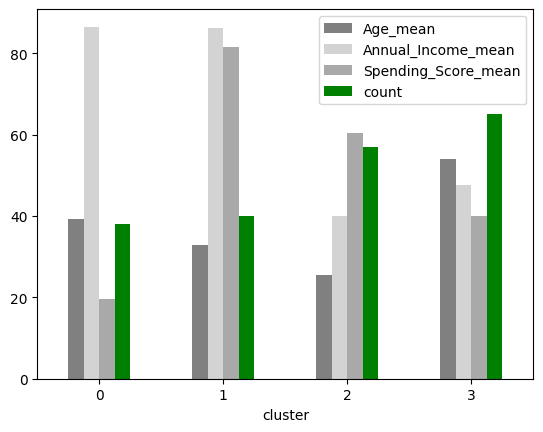

In [ ]:
(mall_customers_copy
 .groupby('cluster')
 .agg(Age_mean=('Age', 'mean'),
    Annual_Income_mean=('Annual Income (k$)', 'mean'),
    Spending_Score_mean=('Spending Score (1-100)', 'mean'),
    count=('CustomerID', 'count'))
 .plot(kind='bar', rot=0, color=['gray','lightgray','darkgray', 'green'])
 )

plt.show()

__Example: bank customer segmentation for loan marketing campagne__

Goal:
1. segment customers for loan marketing campagne
2. identify which clusters/segments have the highest propensity to respond to the campaign.

Key features:
- Experience: The work experience of the customer in years
- Income: The estimated annual income of the customer (thousands of US - dollars)
- CCAvg: The average spending on credit cards per month (thousands of US - dollars)
- Mortgage: The value of the customer's house mortgage (if any)
- Age: The age (in years) of the customer

## Segmentation and selecting the best features for clustering

### Cluster mall customers via Mean-shift clustering

In [ ]:
import pandas as pd
import numpy as np